In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession


In [3]:
spark = SparkSession.builder.appName('Match Analysis and prediction').getOrCreate()


In [4]:
#Load pre-processed data
df = spark.read.format('csv').option('header', 'true').load('cleaned_Cric_summary.csv')
df

DataFrame[_c0: string, season: string, id: string, match_between: string, home_team: string, away_team: string, toss_won: string, decision: string, 1st_inning_score: string, 2nd_inning_score: string, home_score: string, away_score: string, winner: string, result: string, venue: string, home_captain: string, away_captain: string, player_of_the_match: string, super_over: string, home_overs: string, home_runs: string, home_wickets: string, home_boundaries: string, away_overs: string, away_runs: string, away_wickets: string, away_boundaries: string, home_key_batsman: string, home_key_bowler: string, away_key_batsman: string, away_key_bowler: string, part_of_the_day: string]

In [5]:
df_filtered = df.filter((df['home_team'] == 'SRH') & (df['away_team'] == 'RCB'))
df_filtered.show()

+---+------+-------+-------------+---------+---------+--------+----------+----------------+----------------+----------+----------+------+--------------------+--------------------+-----------------+--------------+--------------------+----------+----------+---------+------------+---------------+----------+---------+------------+---------------+--------------------+--------------------+--------------------+--------------------+---------------+
|_c0|season|     id|match_between|home_team|away_team|toss_won|  decision|1st_inning_score|2nd_inning_score|home_score|away_score|winner|              result|               venue|     home_captain|  away_captain| player_of_the_match|super_over|home_overs|home_runs|home_wickets|home_boundaries|away_overs|away_runs|away_wickets|away_boundaries|    home_key_batsman|     home_key_bowler|    away_key_batsman|     away_key_bowler|part_of_the_day|
+---+------+-------+-------------+---------+---------+--------+----------+----------------+----------------+--

In [6]:
df.describe().show()


+-------+------------------+------------------+-----------------+-------------+---------+---------+--------+----------+----------------+----------------+----------+----------+------+--------------------+--------------------+------------+------------+-------------------+----------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+--------------------+--------------------+--------------------+--------------------+---------------+
|summary|               _c0|            season|               id|match_between|home_team|away_team|toss_won|  decision|1st_inning_score|2nd_inning_score|home_score|away_score|winner|              result|               venue|home_captain|away_captain|player_of_the_match|super_over|        home_overs|         home_runs|      home_wickets|  home_boundaries|        away_overs|        away_runs|     away_wickets|   away_boundaries|    home_key_batsman|     home_key_bowl

In [7]:
from pyspark.sql.functions import when

df = df.withColumn('toss_win_match_win', when(df['toss_won'] == df['winner'], 'Yes').otherwise('No'))
df.show()

+---+------+-------+-------------+---------+---------+--------+----------+----------------+----------------+----------+----------+------+--------------------+--------------------+---------------+---------------+--------------------+----------+----------+---------+------------+---------------+----------+---------+------------+---------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+
|_c0|season|     id|match_between|home_team|away_team|toss_won|  decision|1st_inning_score|2nd_inning_score|home_score|away_score|winner|              result|               venue|   home_captain|   away_captain| player_of_the_match|super_over|home_overs|home_runs|home_wickets|home_boundaries|away_overs|away_runs|away_wickets|away_boundaries|    home_key_batsman|     home_key_bowler|    away_key_batsman|     away_key_bowler|part_of_the_day|toss_win_match_win|
+---+------+-------+-------------+---------+---------+--------+----------+

In [8]:
from pyspark.sql.functions import count

toss_decision_wins = df.groupBy('decision').agg(count(when(df['toss_win_match_win'] == 'Yes', True)), count('id'))
toss_decision_wins = toss_decision_wins.withColumnRenamed('count(CASE WHEN (toss_win_match_win = Yes) THEN true END)', 'toss_wins').withColumnRenamed('count(id)', 'total_matches')
toss_decision_wins.show()


+----------+---------+-------------+
|  decision|toss_wins|total_matches|
+----------+---------+-------------+
| BAT FIRST|      153|          344|
|BOWL FIRST|      332|          591|
+----------+---------+-------------+



In [9]:
from pyspark.sql.functions import round

toss_decision_wins = toss_decision_wins.withColumn('toss_win_percentage', round(toss_decision_wins['toss_wins'] / toss_decision_wins['total_matches'] * 100, 2))
toss_decision_wins.show()

+----------+---------+-------------+-------------------+
|  decision|toss_wins|total_matches|toss_win_percentage|
+----------+---------+-------------+-------------------+
| BAT FIRST|      153|          344|              44.48|
|BOWL FIRST|      332|          591|              56.18|
+----------+---------+-------------+-------------------+



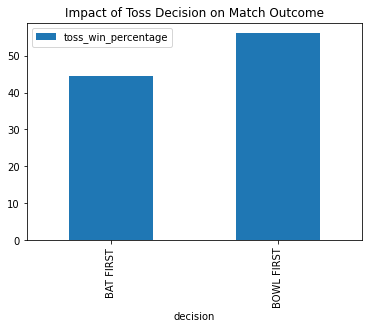

In [10]:
import matplotlib.pyplot as plt

toss_decision_wins_pd = toss_decision_wins.toPandas()
toss_decision_wins_pd.plot(kind='bar', x='decision', y='toss_win_percentage', title='Impact of Toss Decision on Match Outcome')
plt.show()


In [11]:
team_wins = df.groupBy('winner').agg(count('id').alias('wins'))
#team_wins.orderBy(team_wins['wins'].desc()).show(truncate=False)
team_wins.show()

+------+----+
|winner|wins|
+------+----+
|   KKR| 115|
| Kochi|   6|
|    DC|  94|
|    GL|  13|
|    RR|  94|
|   LSG|   9|
|    MI| 131|
|    GT|  12|
|   CSK| 122|
|   SRH| 103|
|   RCB| 108|
|   RPS|  15|
|   PWI|  12|
|  PBKS| 101|
+------+----+



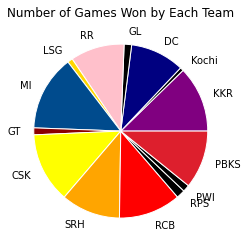

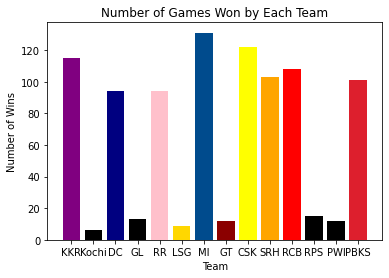

In [12]:
team_wins_pd = team_wins.toPandas()

# Plot a pie chart of the number of games won by each team
colors = ['#800080','#000000','#000080','#000000','#FFC0CB','#FFD700','#004b8d','#8b0000','#FFFF00','#FFA500','#FF0000','#000000','#000000','#DD1F2D']

plt.pie(team_wins_pd['wins'], labels=team_wins_pd['winner'] , labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' } ,colors = colors)
plt.title('Number of Games Won by Each Team')
plt.show()

plt.bar(team_wins_pd['winner'], team_wins_pd['wins'], color = colors)
plt.xlabel('Team')
plt.ylabel('Number of Wins')
plt.title('Number of Games Won by Each Team')
plt.show()

In [13]:
# Group the data by season and winner, and count the number of rows for each group
season_team_wins = df.groupBy('season', 'winner').agg(count('id').alias('wins'))

# Show the results
season_team_wins.orderBy(season_team_wins['season'].asc() , season_team_wins['wins'].desc()).show()

+------+------+----+
|season|winner|wins|
+------+------+----+
|  2008|    RR|  13|
|  2008|  PBKS|  10|
|  2008|   CSK|   9|
|  2008|    MI|   7|
|  2008|   KKR|   6|
|  2008|    DC|   5|
|  2008|   RCB|   4|
|  2008|   SRH|   2|
|  2009|   RCB|   9|
|  2009|   SRH|   8|
|  2009|    DC|   8|
|  2009|   CSK|   8|
|  2009|  PBKS|   7|
|  2009|    MI|   5|
|  2009|    RR|   5|
|  2009|   KKR|   4|
|  2010|    MI|  11|
|  2010|   CSK|  10|
|  2010|   RCB|   8|
|  2010|    DC|   7|
+------+------+----+
only showing top 20 rows



In [14]:
# Group the data by season and winner, and count the number of rows for each group
#season_team_wins = df.groupBy('season', 'winner').agg(count('id').alias('wins'))

# Show the results
#season_team_wins = season_team_wins.orderBy(season_team_wins['season'].asc(), season_team_wins['wins'].desc())

In [15]:
# Get the distinct values of the season column
seasons = [row['season'] for row in season_team_wins.select('season').distinct().collect()]

# Loop through the seasons and create separate dataframes for each year
yearwise_dataframes = {}
for season in seasons:
    # Filter the data for the current season
    season_data = season_team_wins.filter(season_team_wins.season == season)
    # Store the data in a dictionary with the season as the key
    yearwise_dataframes[season] = season_data
    # Show the data for the current season
    print('Season {}:'.format(season))
    season_data.show()


Season 2016:
+------+------+----+
|season|winner|wins|
+------+------+----+
|  2016|    GL|   9|
|  2016|    MI|   7|
|  2016|   SRH|  11|
|  2016|   KKR|   8|
|  2016|   RPS|   5|
|  2016|   RCB|   9|
|  2016|  PBKS|   4|
|  2016|    DC|   7|
+------+------+----+

Season 2020:
+------+------+----+
|season|winner|wins|
+------+------+----+
|  2020|   RCB|   6|
|  2020|    DC|   8|
|  2020|   KKR|   6|
|  2020|   SRH|   9|
|  2020|    MI|  12|
|  2020|  PBKS|   7|
|  2020|   CSK|   6|
|  2020|    RR|   6|
+------+------+----+

Season 2012:
+------+------+----+
|season|winner|wins|
+------+------+----+
|  2012|   CSK|  10|
|  2012|    DC|   9|
|  2012|    RR|   7|
|  2012|   RCB|   8|
|  2012|   KKR|  12|
|  2012|   SRH|   4|
|  2012|   PWI|   4|
|  2012|    MI|  10|
|  2012|  PBKS|   8|
+------+------+----+

Season 2019:
+------+------+----+
|season|winner|wins|
+------+------+----+
|  2019|    MI|  10|
|  2019|    RR|   5|
|  2019|   SRH|   7|
|  2019|   RCB|   5|
|  2019|   KKR|   6|


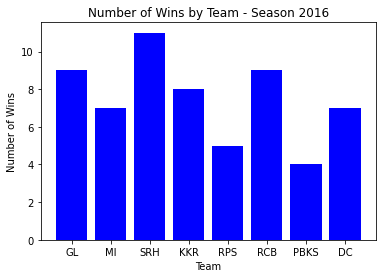

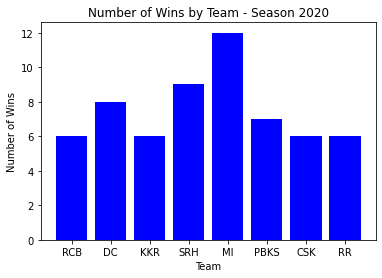

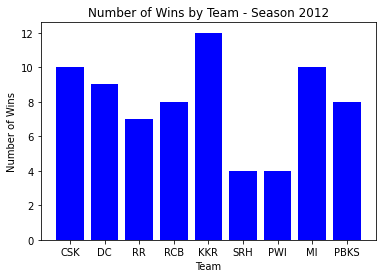

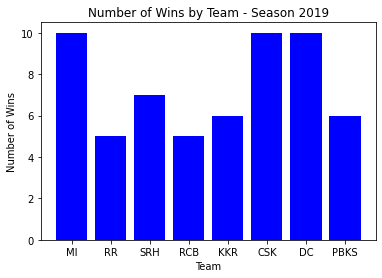

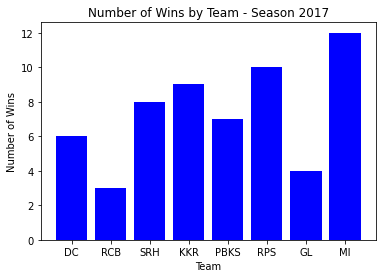

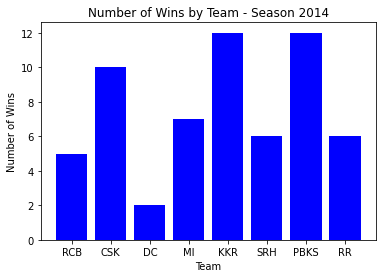

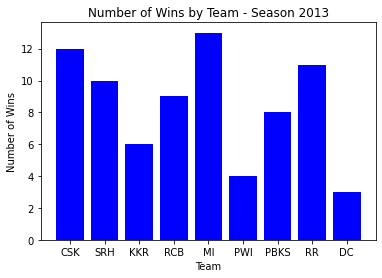

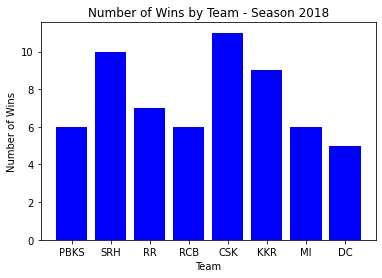

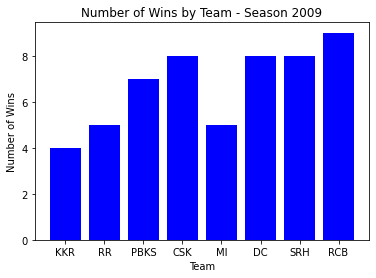

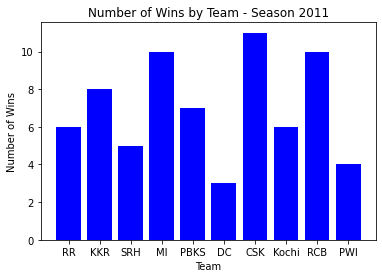

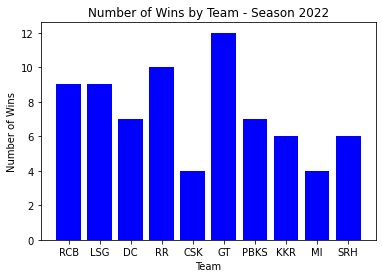

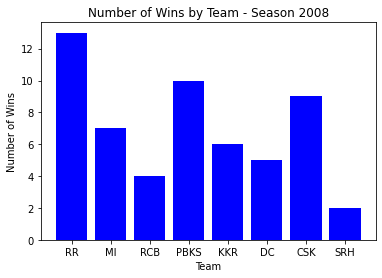

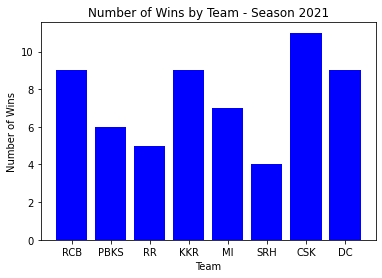

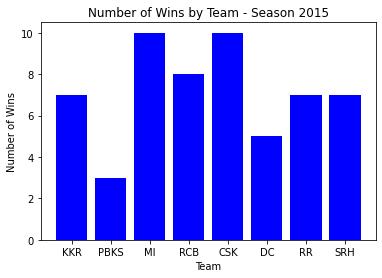

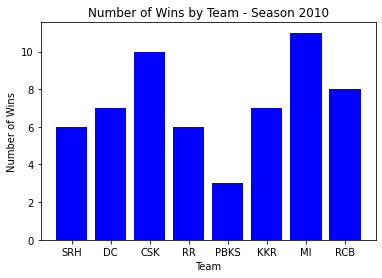

In [16]:
for season in yearwise_dataframes:
    season_data = yearwise_dataframes[season].toPandas()
    plt.bar(season_data['winner'], season_data['wins'], color='blue')
    plt.title('Number of Wins by Team - Season {}'.format(season))
    plt.xlabel('Team')
    plt.ylabel('Number of Wins')
    plt.show()